### Forecast Performance Baseline

Having a baseline for forecast performance is essential, as it serves as a reference point for all other modeling techniques that we apply to solve the problem. If a model's performance is equal to or worse than the baseline, then that particular technique needs to be improved or discarded. The method used to generate the baseline forecast performance should be simple to implement and not take into account any specific details of the problem.

For time series datasets, the persistence algorithm is the most widely used baseline technique. Using the value at the current time step (t), it forecasts the expected result for the following time step (t+1). This algorithm satisfies the properties required for making a good baseline forecast, which are:

- Simplicity: Little to no intelligence or training is needed for this procedure.
- Speed: Making a prediction is computationally simple and can be implemented quickly.
- Determinism: Given the same input, this approach is deterministic, which means it yields the same output.

## CPU forecast with persistence algorithm

In [1]:
import pandas as pd

# Load the data
file_path = 'fastStorage/2013-8/1233.csv'
data = pd.read_csv(file_path, sep=';\t', engine='python')  # specifying sep and engine due to the unique separator

# Display the first few rows of the dataframe to understand its structure
data.head()


,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,4,11703.997976,353.070606,3.016667,8388608.0,1.258289e+06,0.066667,4.133333,11.533333,9.933333
1,1376315146,4,11703.997976,544.235906,4.650000,8388608.0,1.101702e+06,5.000000,2.466667,31.466667,39.466667
2,1376315446,4,11703.997976,1423.986420,12.166667,8388608.0,1.918193e+06,22.133333,76.666667,59.933333,104.733333
3,1376315746,4,11703.997976,415.491928,3.550000,8388608.0,1.946155e+06,0.066667,2.600000,20.933333,42.466667
4,1376316046,4,11703.997976,204.819965,1.750000,8388608.0,1.353359e+06,68.133333,4.066667,7.666667,103.333333


In [2]:
# Adjusting the timestamp to reflect the correct year and month ("2013-08")

# We will recalculate the timestamp considering that each measurement was taken every 5 minutes starting from August 2013
# Assuming the first record starts at the beginning of August 2013
start_date = "2013-08-01 00:00:00"
start_timestamp = pd.to_datetime(start_date)

# Generating timestamps for each row, assuming 5-minute intervals
timestamps = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(data))]

# Assigning the new timestamps to the dataframe
data['Corrected Timestamp'] = timestamps

# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['Corrected Timestamp', 'CPU usage [%]']].copy()
memory_usage_dataset_with_corrected_timestamp = data[['Corrected Timestamp', 'Memory usage [KB]']].copy()

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp.head(), memory_usage_dataset_with_corrected_timestamp.head()


(  Corrected Timestamp  CPU usage [%]
 0 2013-08-01 00:00:00       3.016667
 1 2013-08-01 00:05:00       4.650000
 2 2013-08-01 00:10:00      12.166667
 3 2013-08-01 00:15:00       3.550000
 4 2013-08-01 00:20:00       1.750000,
   Corrected Timestamp  Memory usage [KB]
 0 2013-08-01 00:00:00       1.258289e+06
 1 2013-08-01 00:05:00       1.101702e+06
 2 2013-08-01 00:10:00       1.918193e+06
 3 2013-08-01 00:15:00       1.946155e+06
 4 2013-08-01 00:20:00       1.353359e+06)

## Plot CPU 

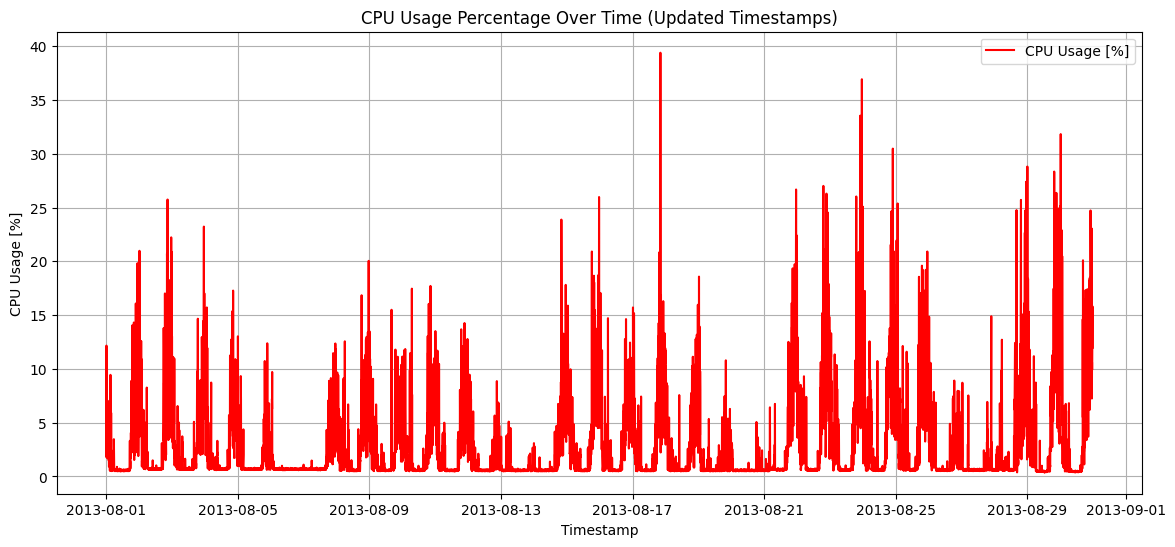

In [3]:
import matplotlib.pyplot as plt
# Plot CPU usage in terms of percentage
plt.figure(figsize=(14, 6))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['Corrected Timestamp'], cpu_usage_dataset_with_corrected_timestamp['CPU usage [%]'], label='CPU Usage [%]', color='red')
plt.title('CPU Usage Percentage Over Time (Updated Timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage [%]')
plt.grid(True)
plt.legend()
plt.show()

## Plot Memory

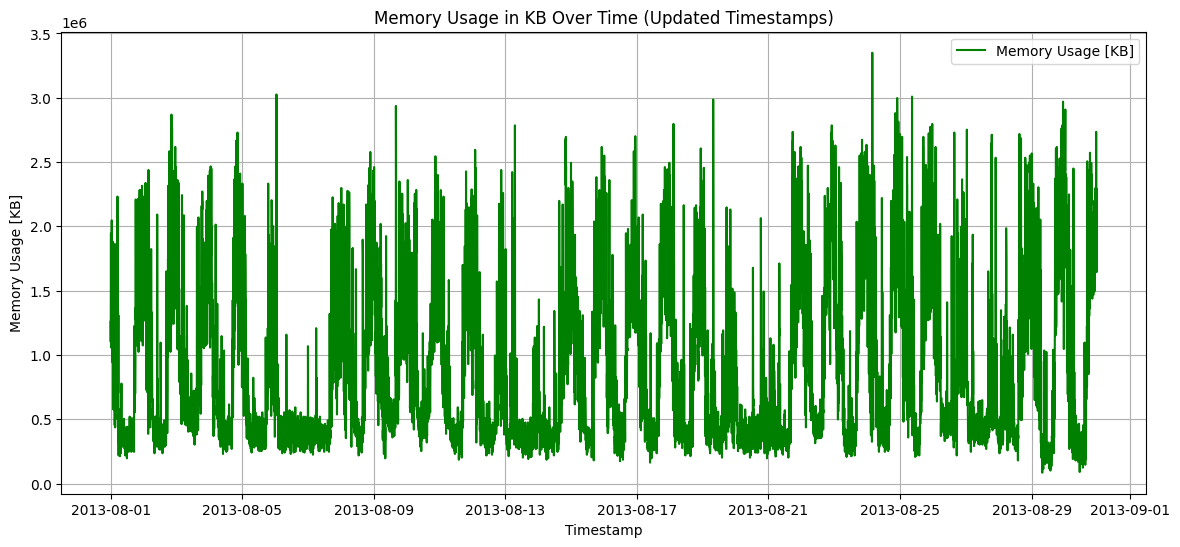

In [4]:
import matplotlib.pyplot as plt
# Plot CPU usage in terms of percentage
plt.figure(figsize=(14, 6))
plt.plot(memory_usage_dataset_with_corrected_timestamp['Corrected Timestamp'], memory_usage_dataset_with_corrected_timestamp['Memory usage [KB]'], label='Memory Usage [KB]', color='green')
plt.title('Memory Usage in KB Over Time (Updated Timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage [KB]')
plt.grid(True)
plt.legend()
plt.show()

## Create CPU lagged Dataset

In [5]:
# create lagged dataset
cpu_usage_dataset_with_corrected_timestamp['CPU usage [%]_lagged'] = cpu_usage_dataset_with_corrected_timestamp['CPU usage [%]'].shift(1)


# Define the new order of the columns
new_order = ['Corrected Timestamp', 'CPU usage [%]_lagged', 'CPU usage [%]']

# Reorder the columns
data_reordered = cpu_usage_dataset_with_corrected_timestamp[new_order]

print(data_reordered)

     Corrected Timestamp  CPU usage [%]_lagged  CPU usage [%]
0    2013-08-01 00:00:00                   NaN       3.016667
1    2013-08-01 00:05:00              3.016667       4.650000
2    2013-08-01 00:10:00              4.650000      12.166667
3    2013-08-01 00:15:00             12.166667       3.550000
4    2013-08-01 00:20:00              3.550000       1.750000
...                  ...                   ...            ...
8632 2013-08-30 23:20:00             10.616667       9.916667
8633 2013-08-30 23:25:00              9.916667      10.866667
8634 2013-08-30 23:30:00             10.866667      13.016667
8635 2013-08-30 23:35:00             13.016667      15.816667
8636 2013-08-30 23:40:00             15.816667      11.966667

[8637 rows x 3 columns]


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_reordered = data_reordered.dropna()

#Split the data into training and test sets
train, test = train_test_split(data_reordered, test_size=0.2, shuffle=False)

# Use the lagged cpu_utilization as the prediction
y_true = test['CPU usage [%]']
y_pred = test['CPU usage [%]_lagged']


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 1.83
Mean Squared Error: 13.28
Root Mean Squared Error: 3.64


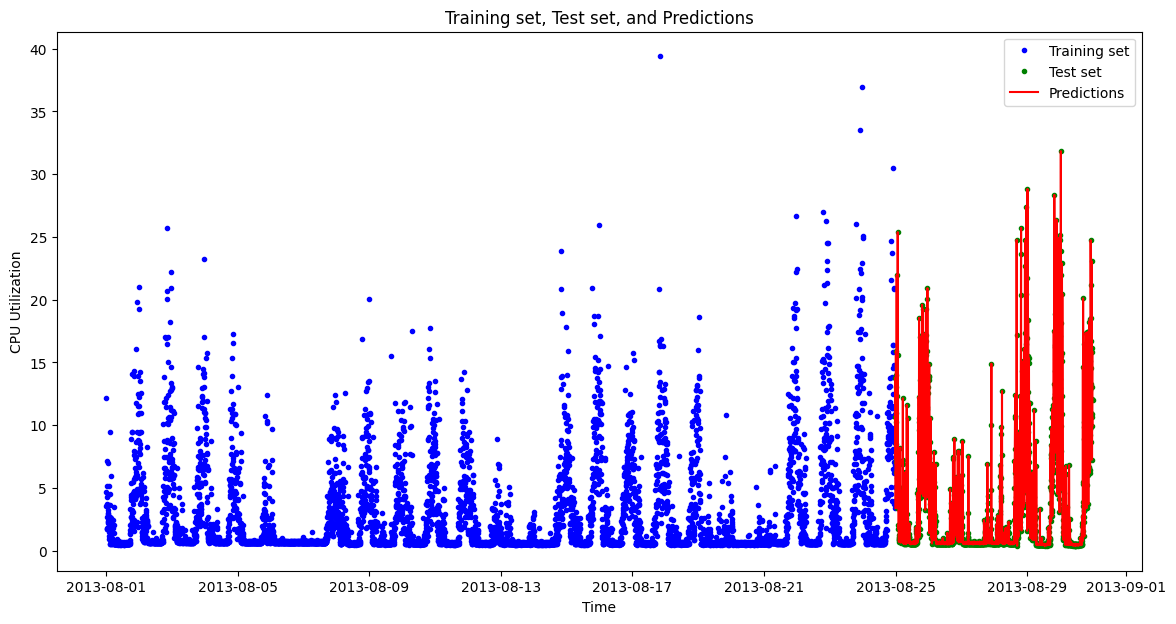

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train['Corrected Timestamp'], train['CPU usage [%]'], 'b.', label='Training set')
plt.plot(test['Corrected Timestamp'], test['CPU usage [%]'], 'g.', label='Test set')
plt.plot(test['Corrected Timestamp'], y_pred, 'r-', label='Predictions')

plt.title('Training set, Test set, and Predictions')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.legend()
plt.show()

## Memory forecast with persistence algorithm

In [8]:
# create lagged dataset
memory_usage_dataset_with_corrected_timestamp['Memory usage [KB]_lagged'] = memory_usage_dataset_with_corrected_timestamp['Memory usage [KB]'].shift(1)


# Define the new order of the columns
new_order = ['Corrected Timestamp', 'Memory usage [KB]_lagged', 'Memory usage [KB]']

# Reorder the columns
data_reordered = memory_usage_dataset_with_corrected_timestamp[new_order]

print(data_reordered)

     Corrected Timestamp  Memory usage [KB]_lagged  Memory usage [KB]
0    2013-08-01 00:00:00                       NaN       1.258289e+06
1    2013-08-01 00:05:00              1.258289e+06       1.101702e+06
2    2013-08-01 00:10:00              1.101702e+06       1.918193e+06
3    2013-08-01 00:15:00              1.918193e+06       1.946155e+06
4    2013-08-01 00:20:00              1.946155e+06       1.353359e+06
...                  ...                       ...                ...
8632 2013-08-30 23:20:00              1.778383e+06       1.845492e+06
8633 2013-08-30 23:25:00              1.845492e+06       1.644164e+06
8634 2013-08-30 23:30:00              1.644164e+06       1.862270e+06
8635 2013-08-30 23:35:00              1.862270e+06       2.169851e+06
8636 2013-08-30 23:40:00              2.169851e+06       2.287293e+06

[8637 rows x 3 columns]


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_reordered = data_reordered.dropna()

#Split the data into training and test sets
train, test = train_test_split(data_reordered, test_size=0.2, shuffle=False)

# Use the lagged cpu_utilization as the prediction
y_true = test['Memory usage [KB]']
y_pred = test['Memory usage [KB]_lagged']


mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 257185.91
Mean Squared Error: 148538012017.96
Root Mean Squared Error: 385406.29


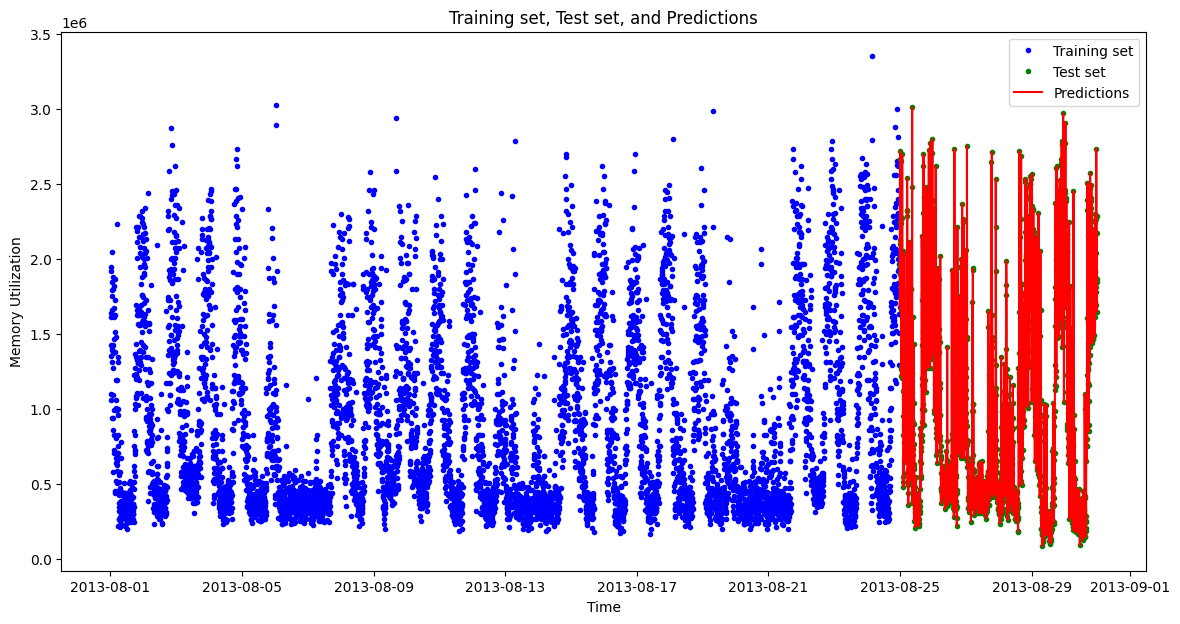

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train['Corrected Timestamp'], train['Memory usage [KB]'], 'b.', label='Training set')
plt.plot(test['Corrected Timestamp'], test['Memory usage [KB]'], 'g.', label='Test set')
plt.plot(test['Corrected Timestamp'], y_pred, 'r-', label='Predictions')

plt.title('Training set, Test set, and Predictions')
plt.xlabel('Time')
plt.ylabel('Memory Utilization')
plt.legend()
plt.show()